In [204]:
#bibliotecas
import pandas as pd
import psycopg2 as pg
import pandas.io.sql as psql

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sb 
import squarify
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

#plt.style.use('seaborn-dark')
#plt.rc('figure', figsize=(12, 6) )

import warnings
warnings.filterwarnings('ignore')

In [205]:
#postgreSQL connection 
conn = pg.connect(
    host = 'localhost',
    dbname = 'postgres',
    user = 'postgres',
    port = 5432, 
    password = 'Trendminer*2022')

#query01
Query_SQL = (
    '''
    
    select 
        case
            when ibge.gender = 'male' then 'Homens'
            when ibge.gender = 'female' then 'Mulheres'
            end as "Gender",
        count(*) as "leads(#)"
            
    from sales.customers as cust
    left join temp_tables.ibge_genders as ibge
        on lower(cust.first_name) = lower(ibge.first_name)
    group by ibge.gender
    '''
)

#dataframe pandas
df_gender = psql.read_sql( Query_SQL, conn)



In [206]:
df_gender.head()

,Gender,leads(#)
0,Mulheres,15106
1,Homens,10003


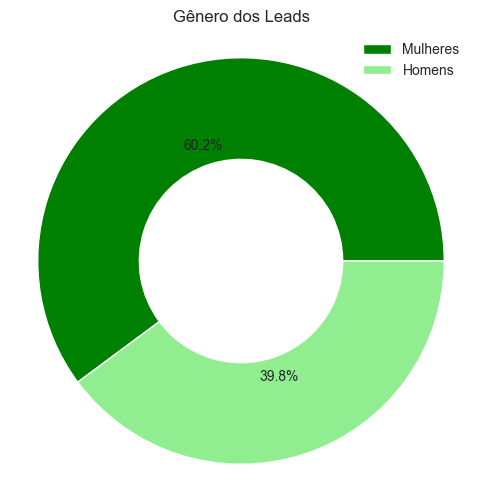

In [207]:
my_pie,_,_ = plt.pie(df_gender['leads(#)'],
                     radius = 1.1,
                     colors=['green', 'lightgreen'],
                     autopct="%.1f%%")

plt.setp(my_pie, width=0.55, edgecolor='white') 
plt.legend(df_gender['Gender'])
plt.title('Gênero dos Leads')
plt.show()

In [208]:
#query02
Query_SQL = (
    '''
    
    select 
        case
            when professional_status = 'freelancer' then 'freelancer'
            when professional_status = 'freelancer' then 'freelancer'
            when professional_status = 'clt' then 'clt' 
            when professional_status = 'self_employed' then 'autônomo(a)'
            when professional_status = 'other' then 'outros'
            when professional_status = 'businessman' then 'empresário(a)'
            when professional_status = 'civil_servant' then 'funcionário(a) público(a)'
            when professional_status = 'student' then 'estudante' 
            end as "Professional_Status",
        ((count(*)::float) / (select count(*) from sales.customers)) * 100 as "leads(%)"
            
    from sales.customers
    group by professional_status
    order by "leads(%)" desc
    
    '''
)

#dataframe pandas
df_sts_prof = psql.read_sql( Query_SQL, conn)

In [209]:
df_sts_prof['leads(%)'] = df_sts_prof['leads(%)'] .round(2) #ajustando as casas decimais
df_sts_prof.head(10)



,Professional_Status,leads(%)
0,clt,64.94
1,outros,9.04
2,empresário(a),7.54
3,autônomo(a),7.20
4,freelancer,5.29
5,None,4.26
6,funcionário(a) público(a),1.71
7,estudante,0.00


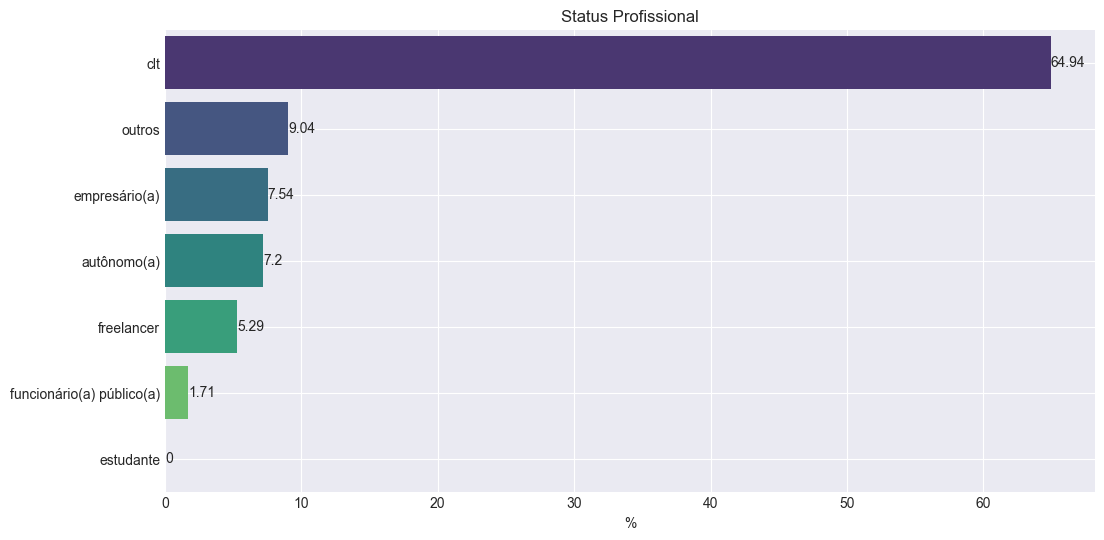

In [210]:
ax = sns.barplot(data=df_sts_prof.reset_index(), x='leads(%)', y='Professional_Status', palette='viridis', orient='h')
plt.title('Status Profissional')
plt.bar_label(ax.containers[0], label_type='edge')
plt.xlabel('%')
plt.ylabel('')
plt.grid(True)

In [211]:
#query03
Query_SQL = (
    '''
    
    select 
        case
            when datediff('years', birth_date, current_date) < 20 then '0-20 anos'
            when datediff('years', birth_date, current_date) < 40 then '20-40 anos'
            when datediff('years', birth_date, current_date) < 60 then '40-60 anos'
            when datediff('years', birth_date, current_date) < 80 then '60-80 anos'
            else '80+' end "faixa etária",
            ((count(*)::float) / (select count(*) from sales.customers)) * 100 as "leads(%)"
            
    from sales.customers
    group by "faixa etária" 
    order by "faixa etária" desc
    
    '''
)

#dataframe pandas
df_age = psql.read_sql( Query_SQL, conn)

In [212]:
df_age['leads(%)'] = df_age['leads(%)'] .round(2) #ajustando as casas decimais
df_age.head()

,faixa etária,leads(%)
0,80+,1.69
1,60-80 anos,19.44
2,40-60 anos,31.46
3,20-40 anos,47.41


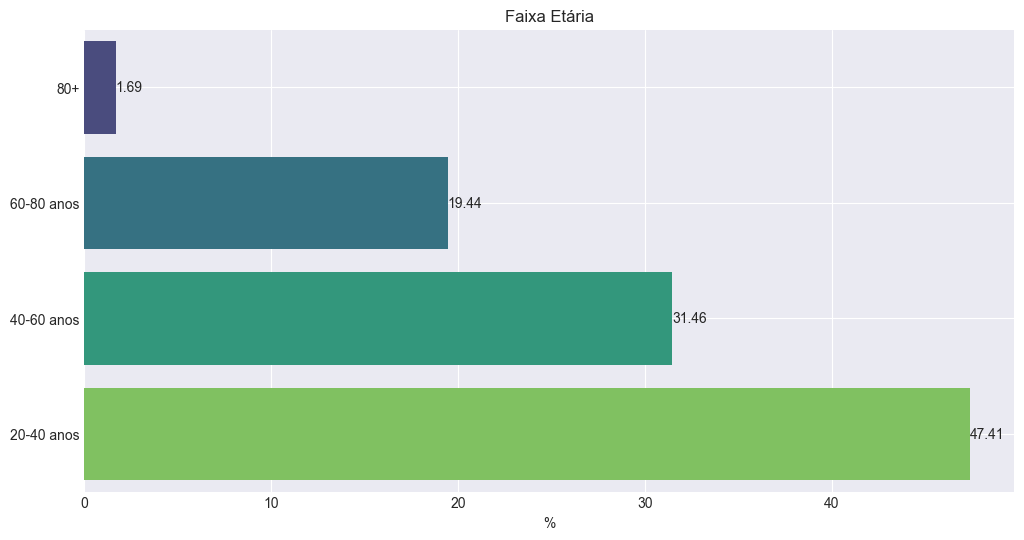

In [213]:
ax = sns.barplot(data=df_age.reset_index(), x='leads(%)', y='faixa etária', palette='viridis', orient='h')
plt.title('Faixa Etária')
plt.bar_label(ax.containers[0], label_type='edge')
plt.xlabel('%')
plt.ylabel('')
plt.grid(True)

In [214]:
#query04
Query_SQL = (
    '''
    
    select 
        case
            when income < 5000 then '0-5000'
            when income < 10000 then '5000-10000'
            when income < 15000 then '10000-15000'
            when income < 20000 then '15000-20000'
            else '20000+' end "Faixa salarial",
            ((count(*)::float) / (select count(*) from sales.customers)) * 100 as "Leads(%)",
        case
            when income < 5000 then 1
            when income < 10000 then 2
            when income < 15000 then 3
            when income < 20000 then 4
            else 5 end "ordem"
            
    from sales.customers
    group by "Faixa salarial" , "ordem"
    order by "ordem" desc
    
    '''
)

#dataframe pandas
df_income = psql.read_sql( Query_SQL, conn)

In [215]:
df_income['Leads(%)'] = df_income['Leads(%)'].round(2) #ajustando as casas decimais
df_income.head()

,Faixa salarial,Leads(%),ordem
0,20000+,1.60,5
1,15000-20000,1.77,4
2,10000-15000,9.54,3
3,5000-10000,71.03,2
4,0-5000,16.06,1


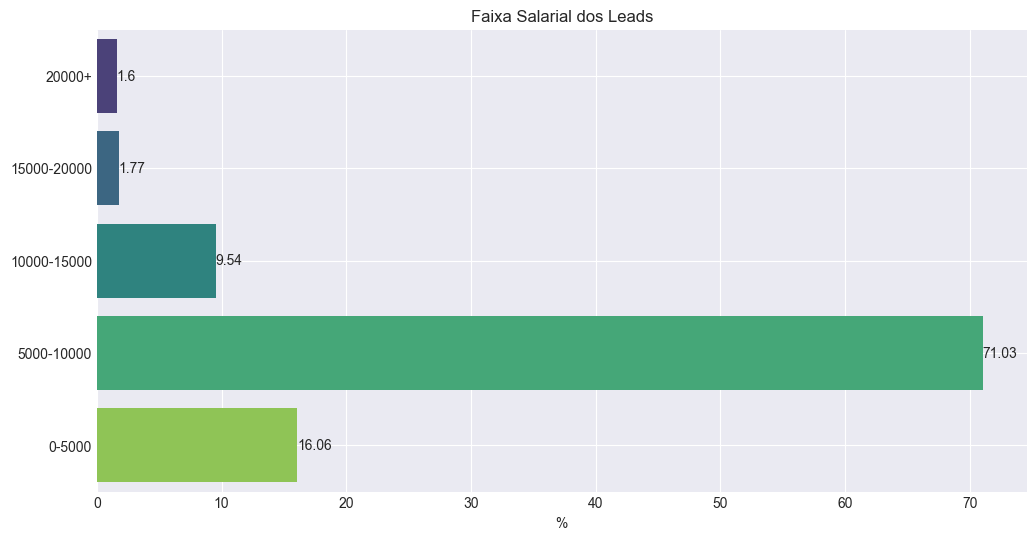

In [216]:
ax = sns.barplot(data=df_income.reset_index(), x='Leads(%)', y='Faixa salarial', palette='viridis', orient='h')
plt.title('Faixa Salarial dos Leads')
plt.bar_label(ax.containers[0], label_type='edge')
plt.xlabel('%')
plt.ylabel('')
plt.grid(True)

In [217]:
#query05
Query_SQL = (
    '''
    
    with
        classificacao_veiculos as (

            select 
                fun.visit_page_date,
                pro.model_year,
                extract('year' from visit_page_date) - pro.model_year::int as idade_veiculo,
                case
                    when (extract('year' from visit_page_date) - pro.model_year::int) <= 2 then 'novo'
                    else 'seminovo'
                    end as "classificaçao do veiculo"
                    
            from sales.funnel as fun
            left join sales.products as pro
                on fun.product_id = pro.product_id

        )      
        
    select 
        "classificaçao do veiculo",
        count(*) as "veiculos visitados (#)"
    from classificacao_veiculos
    group by "classificaçao do veiculo" 
    
    '''
)

#dataframe pandas
df_cars = psql.read_sql( Query_SQL, conn)

In [218]:
df_cars.head()

,classificaçao do veiculo,veiculos visitados (#)
0,novo,1162
1,seminovo,29418


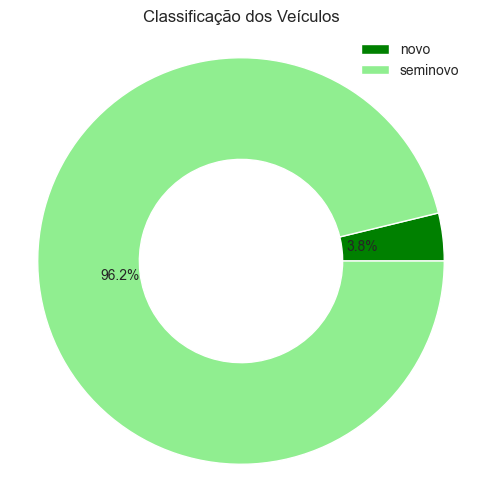

In [219]:
my_pie,_,_ = plt.pie(df_cars['veiculos visitados (#)'],
                     radius = 1.1,
                     colors=['green', 'lightgreen'], 
                     autopct="%.1f%%")

plt.setp(my_pie, width=0.55, edgecolor='white') 
plt.legend(df_cars['classificaçao do veiculo'])
plt.title('Classificação dos Veículos')
plt.show()

In [220]:
#query06
Query_SQL = (
    '''
    
    with
        faixa_de_idade_dos_veiculos as (

            select 
                fun.visit_page_date,
                pro.model_year,
                extract('year' from visit_page_date) - pro.model_year::int as idade_veiculo,
                case
                    when (extract('year' from visit_page_date) - pro.model_year::int) <= 2 then 'até 2 anos'
                    when (extract('year' from visit_page_date) - pro.model_year::int) <= 4 then '2 a 4 anos'
                    when (extract('year' from visit_page_date) - pro.model_year::int) <= 6 then '4 a 6 anos'
                    when (extract('year' from visit_page_date) - pro.model_year::int) <= 8 then '6 a 8 anos'
                    when (extract('year' from visit_page_date) - pro.model_year::int) <= 10 then '8 a 10 anos'
                    else 'acima de 10 anos'
                    end as "idade do veiculo",
                    
                case
                    when (extract('year' from visit_page_date) - pro.model_year::int) <= 2 then 1
                    when (extract('year' from visit_page_date) - pro.model_year::int) <= 4 then 2
                    when (extract('year' from visit_page_date) - pro.model_year::int) <= 6 then 3
                    when (extract('year' from visit_page_date) - pro.model_year::int) <= 8 then 4
                    when (extract('year' from visit_page_date) - pro.model_year::int) <= 10 then 5
                    else 6
                    end as "ordem"
                    
            from sales.funnel as fun
            left join sales.products as pro
                on fun.product_id = pro.product_id         
        )      
        
    select 
        "idade do veiculo",
        (count(*)::float / (select count (*) from sales.funnel)) * 100  as "veiculos visitados (%)"
    from faixa_de_idade_dos_veiculos
    group by "idade do veiculo" , ordem
    order by ordem desc
    
    '''
)

#dataframe pandas
df_age_cars = psql.read_sql( Query_SQL, conn)

In [221]:
df_age_cars['veiculos visitados (%)'] = df_age_cars['veiculos visitados (%)'] .round(2) #ajustando as casas decimais
df_age_cars.head(10)

,idade do veiculo,veiculos visitados (%)
0,acima de 10 anos,22.92
1,8 a 10 anos,24.77
2,6 a 8 anos,19.63
3,4 a 6 anos,18.10
4,2 a 4 anos,10.78
5,até 2 anos,3.80


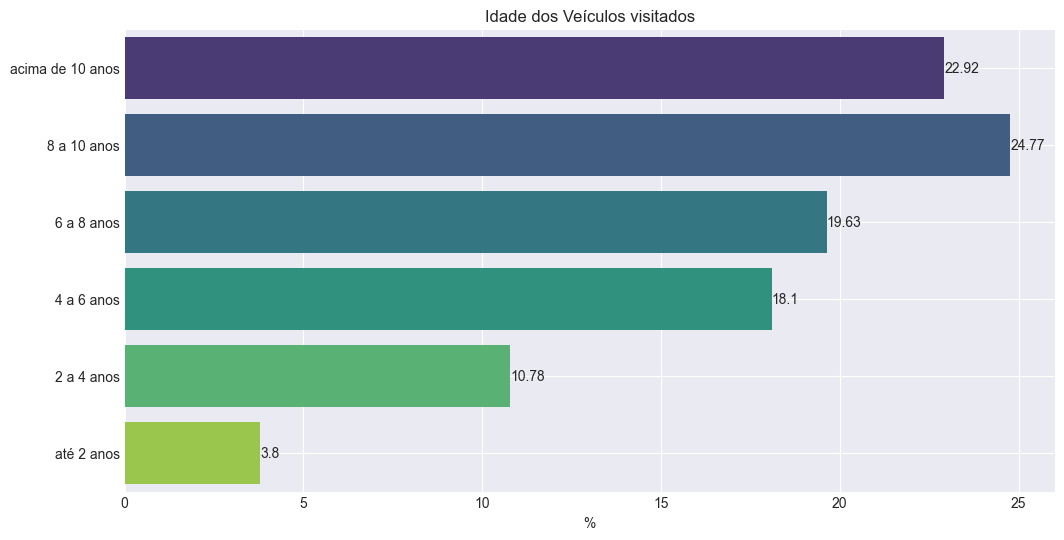

In [222]:
ax = sns.barplot(data=df_age_cars.reset_index(), x='veiculos visitados (%)', y='idade do veiculo', palette='viridis', orient='h')
plt.title('Idade dos Veículos visitados')
plt.bar_label(ax.containers[0], label_type='edge')
plt.xlabel('%')
plt.ylabel('')
plt.grid(True)

In [223]:
#query07
Query_SQL = (
    '''
    
    select 
        pro.brand,
        pro.model,     
        count(*) as "visitas"
            
    from sales.funnel as fun
    left join sales.products as pro
        on fun.product_id = pro.product_id
    group by pro.brand, pro.model
    order by pro.brand, pro.model, "visitas" 
    '''
)

#dataframe pandas
df_brand_vis = psql.read_sql( Query_SQL, conn)

In [224]:
df_brand_vis.head(15)

,brand,model,visitas
0,AUDI,A1,18
1,AUDI,A3,32
2,AUDI,A4,19
3,AUDI,A5,7
4,AUDI,A6,1
5,AUDI,A7,1
6,AUDI,Q3,30
7,AUDI,Q5,6
8,AUDI,Q7,4
9,AUDI,R8,1


Text(0.5, 1.0, 'Top 20 dos modelos mais visitados')

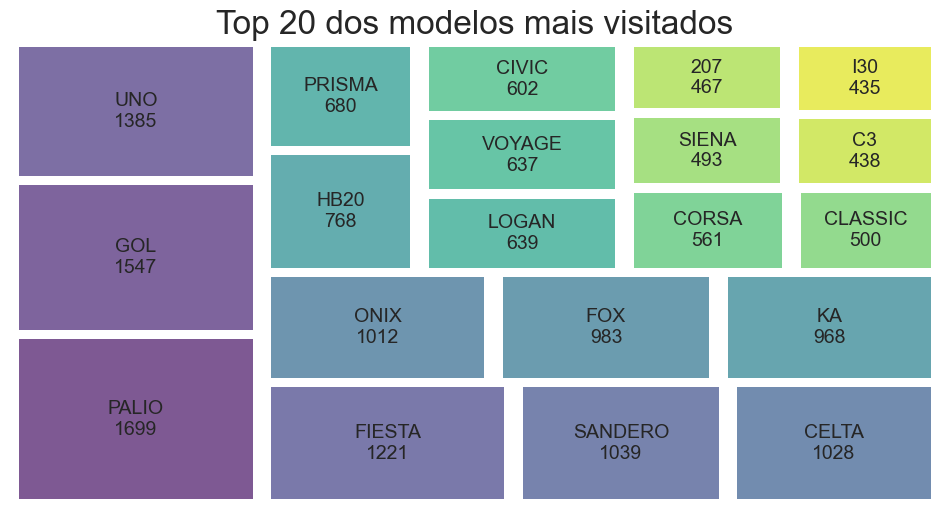

In [225]:
#ranking dos 20 mais visitados
top20_visitas = df_brand_vis.loc[:, ['model', "visitas"]].sort_values(by="visitas", ascending=False)[:20]

#plot os dados nas labels
labels = ["%s\n%.0f" % (label) for label in zip(top20_visitas.model, top20_visitas.visitas)]

plt.axis("off") 
ax = squarify.plot(top20_visitas['visitas'],
                     label=labels, 
                     color=sb.color_palette("viridis", len(top20_visitas['model'].value_counts())), 
                     pad=1, 
                     alpha = 0.7,
                     text_kwargs={'fontsize': 14}) 
ax.set_title("Top 20 dos modelos mais visitados", fontsize=24)

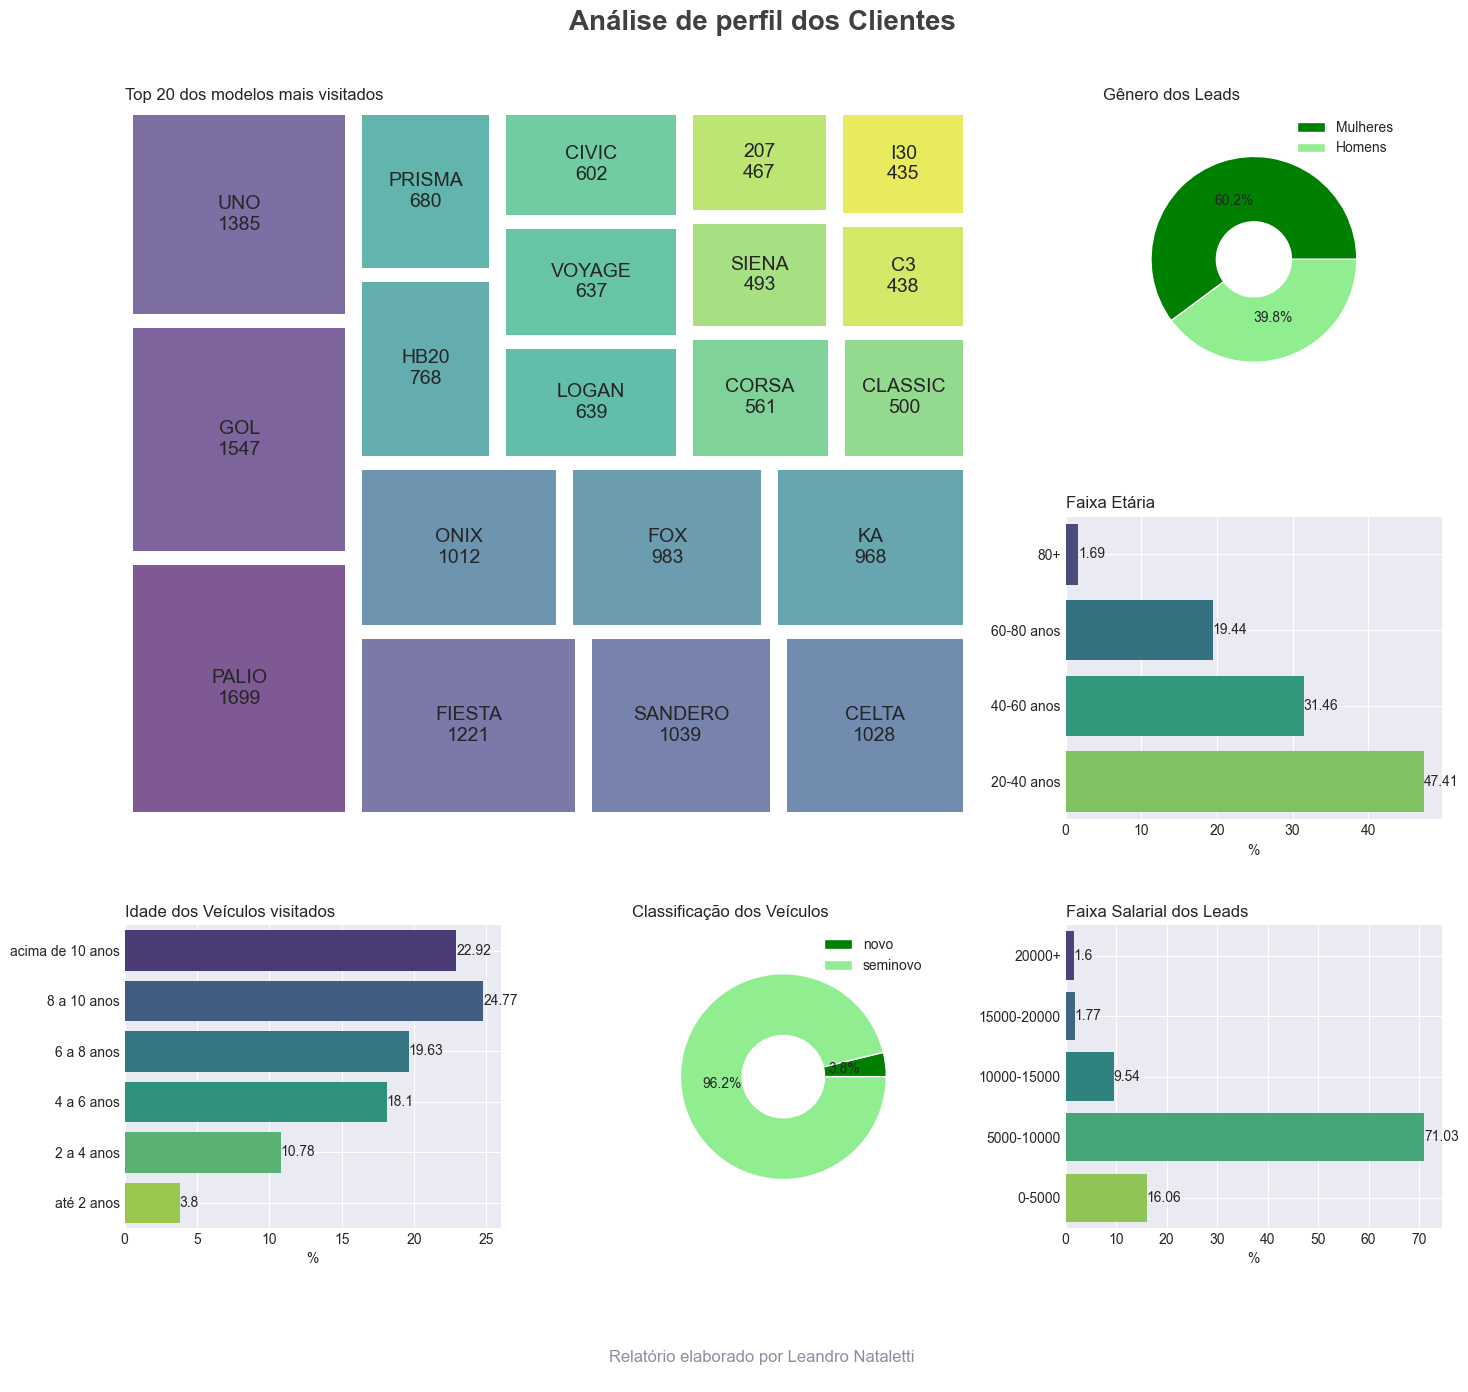

In [226]:
Report = plt.figure( figsize=(17, 14) )

# Titulo da figura
plt.suptitle('Análise de perfil dos Clientes', fontsize=20, color='#404040', fontweight=600) 

# Lista com os eixos
Eixos = [ None for Loop in range(10) ]

Estrutura_Grid = (3, 3)

Eixos[3] = plt.subplot2grid( Estrutura_Grid, (0, 0), colspan=2, rowspan=2 )
top20_visitas = df_brand_vis.loc[:, ['model', "visitas"]].sort_values(by="visitas", ascending=False)[:20]

labels = ["%s\n%.0f" % (label) for label in zip(top20_visitas.model, top20_visitas.visitas)]

plt.axis("off") 
ax = squarify.plot(top20_visitas['visitas'],
                     label=labels, 
                     color=sb.color_palette("viridis", len(top20_visitas['model'].value_counts())), 
                     pad=1, 
                     alpha = 0.7,
                     text_kwargs={'fontsize': 14}) 
plt.title("Top 20 dos modelos mais visitados", loc = 'left')

Eixos[4] = plt.subplot2grid( Estrutura_Grid, (0, 2), colspan=1, rowspan=1 )
my_pie,_,_ = plt.pie(df_gender['leads(#)'],
                     radius = .85,
                     colors=['green', 'lightgreen'],
                     autopct="%.1f%%")

plt.setp(my_pie, width=0.54, edgecolor='white') 
plt.legend(df_gender['Gender'])
plt.title('Gênero dos Leads', loc = 'left')

Eixos[5] = plt.subplot2grid( Estrutura_Grid, (1, 2), colspan=1, rowspan=1 )
ax = sns.barplot(data=df_age.reset_index(), x='leads(%)', y='faixa etária', palette='viridis', orient='h')
plt.title('Faixa Etária', loc = 'left')
plt.bar_label(ax.containers[0], label_type='edge')
plt.xlabel('%')
plt.ylabel('')
plt.grid(True)

Eixos[0] = plt.subplot2grid( Estrutura_Grid, (2, 0), colspan=1 )
ax = sns.barplot(data=df_age_cars.reset_index(), x='veiculos visitados (%)', y='idade do veiculo', palette='viridis', orient='h')
plt.title('Idade dos Veículos visitados', loc = 'left')
plt.bar_label(ax.containers[0], label_type='edge')
plt.xlabel('%')
plt.ylabel('')
plt.grid(True)

Eixos[1] = plt.subplot2grid( Estrutura_Grid, (2, 1), colspan=1 )
my_pie,_,_ = plt.pie(df_cars['veiculos visitados (#)'],
                     radius = 0.85,
                     colors=['green', 'lightgreen'], 
                     autopct="%.1f%%")

plt.setp(my_pie, width=0.51, edgecolor='white') 
plt.legend(df_cars['classificaçao do veiculo'])
plt.title('Classificação dos Veículos', loc = 'left')

Eixos[2] = plt.subplot2grid( Estrutura_Grid, (2, 2), colspan=1 )
ax = sns.barplot(data=df_income.reset_index(), x='Leads(%)', y='Faixa salarial', palette='viridis', orient='h')
plt.title('Faixa Salarial dos Leads', loc = 'left')
plt.bar_label(ax.containers[0], label_type='edge')
plt.xlabel('%')
plt.ylabel('')
plt.grid(True)

# Ajustar o layout
plt.subplots_adjust( hspace=0.35, wspace=0.25, top=0.91 )

# Rodapé
Rodape = 
'''
Relatório elaborado por Leandro Nataletti
'''

# Incluindo o rodape no relatorio
Report.text( 0.5, 0, Rodape, ha='center', va='bottom', size=12, color='#938ca1');



In [227]:
#exportando como png
fig = Report.get_figure()
fig.savefig('perfil_leads.png')

In [228]:
#exportando como pdf
fig = Report.get_figure()
fig.savefig('perfil_leads.pdf')

In [229]:
#closing connection
conn.close()